# American Express - Default Prediction

## Table of Content 

- [Desciption](#description)
- [Reduce Data Size](#reduce-data-size)
- [Imports](#imports)
- [Global Constants](#global-constants)
- [Declare Functions and Classes](#declare-functions-and-classes)
  - [Evaluation Function](#evaluation-function)
  - [DeviceQuantileDMatrix ](#devicequantiledmatrix)
  - [Process and Feature Engineer ](#process-and-feature-engineer)
  - [Function For Partitioning Test Data](#function-for-partitioning-test-data)
- [Proprocessing and Feature Engineering](#proprocessing-and-feature-engineering)
- [Training Data](#training-data)
  - [Training](#training)
  - [Performance Evaluation On Training Data](#performance-evaluation-on-training-data)
  - [Predictions On Validation Sets](#predictions-on-validation-set)
  - [Feature Importance](#feature-importance)
- [Test Data](#test-data)
  - [Performance Evaluation On Test Data](#performance-evaluation-on-test-data)
  - [Predictions On Test Data](#predictions-on-test-data)

## Description

In this notebook we build and train an XGBoost model using @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. This XGB model achieves CV 0.792 LB 0.793! When training with XGB, we use a special XGB dataloader called `DeviceQuantileDMatrix` which uses a small GPU memory footprint. This allows us to engineer more additional columns and train with more rows of data. Our feature engineering is performed using [RAPIDS][5] on the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

## Reduce Data Size

This competition's tabular data is 50GB. To engineer features from this data and train models with this data, we need to reduce data size and efficiently use memory and disk first.

* Step 1 - Reduce Data Types: The first step is reducing each column to the least data size possible. Afterward we can choose our file format and whether to save as multiple files or single file.

    * Column customer_ID - Reduce 64 bytes to 4 bytes: This column is a string of length 64 which uses 64 bytes per row. We can convert this to int32 or int64 which only uses 4 bytes or 8 bytes. The technique here is to take the last 16 letters of the hexadecimal string and convert that base16 number into base10 before saving it as int64. Discussion to explain this is [here](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/308635).

    * Column S_2 - Reduce 10 bytes to 3 bytes: This column is a date with time. This column is provided as a string of length 10 which uses 10 bytes per row. If we convert this column with pd.to_datetime() then it becomes only 4 bytes. Alternatively, we can save this column as three columns of `year_last_2_digits`, `month`, and `day` as int8 each and only use 3 bytes per row.

    * 11 Categorical Columns - Reduce 88 bytes to 11 bytes: The 11 columns `['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']` are categorical with maximum 8 values. Therefore each of these columns can be converted into int8 which is 1 byte per row. Originally these columsn were each 8 bytes per row.

    * 177 Numeric Columns - Reduce 1416 bytes to 353 bytes: Lastly there are 177 numerical columns. These columns are float64 with 8 bytes per row. At the bare minimum, we can convert float64 to float32 (4 bytes per row) without losing any important information. We are also discovering that we can convert these to float16 which is 2 bytes per row since we suspect that Amex has added uniform noise. (And column `B_31` has only two values and can be converted to int8, which is 1 byte per row)

The train data has 5,531,451 rows. After the reductions above, we have 4 + 3 + 11 + 353 = 371 bytes per row. Therefore our uncompressed train data size is 2GB. And test data has 11,363,762 rows, therefore the uncompressed test data is 4GB. All the competition data now becomes 6GB instead of 50GB.

## Imports

In [1]:
# CPU Libraries
import pandas as pd, numpy as np

# GPU libraries
import cudf

# Standard library
from functools import reduce

# Machine learning
from sklearn.model_selection import KFold
import xgboost as xgb

# Plotting
import matplotlib.pyplot as plt, gc

print("XGB Version", xgb.__version__)
print("RAPIDS version", cudf.__version__)

XGB Version 1.6.1
RAPIDS version 21.10.01


## Global Constants

In [2]:
# Version name for saved models
VER = 1

# Random seed
SEED = 12

# Fill nan values with int8
NAN_VALUE = -127

# Training data path
TRAIN_PATH = "../input/amex-data-integer-dtypes-parquet-format/train.parquet"

# Target path
LABEL_PATH = "../input/amex-default-prediction/train_labels.csv"

# Test data path
TEST_PATH = "../input/amex-data-integer-dtypes-parquet-format/test.parquet"

# Folds per model
FOLDS = 5

# Train with 100% of the samples each fold or a random subset if < 1.0
TRAIN_SUBSAMPLE = 1.0

# Top x important to visualize
TOP_NUM_FEATURES = 20

# Partition for test data
NUM_PARTS = 4

## Declare Functions and Classes

### Evaluation Function

In [3]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])

    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1] / gini[0] + top_four)

### DeviceQuantileDMatrix

The class below is a customized iterator for passing batches of data into `xgboost.DeviceQuantileDMatrix` and use this `DeviceQuantileDMatrix` for training. The documentations can be found [here](https://xgboost.readthedocs.io/en/latest/python/examples/quantile_data_iterator.html).

In [4]:
class IterLoadForDMatrix(xgb.core.DataIter):
    # Higher batch sizes leads to lower asymptotic test accuracy according to https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
    def __init__(self, df=None, features=None, target=None, batch_size=256 * 1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0  # Set iterator to 0
        self.batch_size = batch_size
        self.batches = int(np.ceil(len(df) / self.batch_size))
        super().__init__()

    def reset(self):
        """Reset the iterator"""
        self.it = 0

    def next(self, input_data):
        """Return the next batch of data."""
        # Return 0 when there's no more data
        if self.it == self.batches:
            return 0

        # Starting row index for the current batch
        a = self.it * self.batch_size
        # Ending row index for the current batch
        # Once (self.it + 1) * self.batch_size exceeds the max number of rows, that means we have arrived at the end of the frame, and last row is the ending index
        b = min((self.it + 1) * self.batch_size, len(self.df))
        # Current batch of training samples
        dt = cudf.DataFrame(self.df.iloc[a:b])
        # The input_data function is passed in by XGBoost who has the similar signature to the ``DMatrix`` constructor
        input_data(data=dt[self.features], label=dt[self.target])
        self.it += 1
        return 1

### Process and Feature Engineer 

In [5]:
def read_file(path="", usecols=None):
    # Load dataframe with user specified columns
    if usecols is not None:
        df = cudf.read_parquet(path, columns=usecols)
    else:
        # Read all columns
        df = cudf.read_parquet(path)
    # Reduce Dtype for customer and date
    # Obtained the last 16 characters and obtain the integer value represented by each customer_ID, finally converting to 'int64' dtype
    df["customer_ID"] = df["customer_ID"].str[-16:].str.hex_to_int().astype("int64")
    # Convert date column from 'object' to datetime
    df.S_2 = cudf.to_datetime(df.S_2)
    # Sort by customer and date (so agg('last') works correctly)
    df = df.sort_values(["customer_ID", "S_2"])
    df = df.reset_index(drop=True)
    # Fill nan
    df = df.fillna(NAN_VALUE)
    print("shape of data:", df.shape)

    return df

In [6]:
def process_and_feature_engineer(df):
    # Feature engineering from https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ["customer_ID", "S_2"]]
    # Categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    # Numerical features
    num_features = [col for col in all_cols if col not in cat_features]

    # Group by customer id and generate new columns ['mean', 'std', 'min', 'max', 'last'] for each col in 'num_features' (5 x len(num_features) total)
    # Could also use df.groupby("customer_ID")[num_features].describe(), but that includes quantiles as well so it may more more wasteful
    test_num_agg = df.groupby("customer_ID")[num_features].agg(
        ["mean", "std", "min", "max", "last"]
    )
    # The test_num_agg.columns map object returns tuples of the form ('parent_col', 'child_col') e.g., ('D_39', 'mean'), ('D_39', 'std'), ...
    # Join the elements of this tuple using an underscore
    test_num_agg.columns = ["_".join(x) for x in test_num_agg.columns]

    # Create features for categorical columns of the form ('B_30_count'), ('B_30_last'), ..., ('D_117', 'nunique'), ...
    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(
        ["count", "last", "nunique"]
    )
    test_cat_agg.columns = ["_".join(x) for x in test_cat_agg.columns]

    # Column bind
    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print("shape after engineering", df.shape)

    return df

### Function For Partitioning Test Data

In [7]:
# Calculate size of each test partition
def get_rows(customers, test, NUM_PARTS, verbose=""):
    # Split customers_ID into 4 parts, each part contains 'chunk' number of ID's at least (floor division rounds down to the nearest integer)
    chunk = len(customers) // NUM_PARTS

    # Report to user
    if verbose != "":
        print(f"We will process {verbose} data as {NUM_PARTS} separate parts.")
        print(f"There will be {chunk} customers in each part (except the last part).")
        print("Below are number of rows in each part:")

    # Instantiate output container
    rows = []

    for k in range(NUM_PARTS):
        # Once we reach the last chunk
        if k == NUM_PARTS - 1:
            # The starting row index will be k*chunk, so we subset the 'customers' series from that position
            cc = customers[k * chunk :]
        else:
            # Chunks before we arrive at the last chunk, (k+1) ensures we include the last row of each chunk
            cc = customers[k * chunk : (k + 1) * chunk]

        # The expression test.loc[test.customer_ID.isin(cc)] returns the rows from 'test' whose 'customer_ID' are in the set of  'customer_ID' as defined in 'cc'
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        # Append number of rows to container
        rows.append(s)

    if verbose != "":
        print(rows)

    return rows, chunk

## Proprocessing and Feature Engineering

In [8]:
# Read in data
print("Reading train data...")
train = read_file(path=TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [9]:
# Feature engineering
train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [10]:
# Add Targets
targets = cudf.read_csv(LABEL_PATH)
# Reduce datatype
targets["customer_ID"] = (
    targets["customer_ID"].str[-16:].str.hex_to_int().astype("int64")
)
# Set index for joining
targets = targets.set_index("customer_ID")
# Left join target onto train using 'customer_ID'
train = train.merge(targets, left_index=True, right_index=True, how="left")
# Reduce dtype
train.target = train.target.astype("int8")
del targets

# Needed to make CV deterministic (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index(inplace=False)

# Features (this is needed for the modeling)
FEATURES = train.columns[1:-1]
print(f"There are {len(FEATURES)} features")

There are 918 features


In [11]:
train.iloc[:5, :]

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,-9223358381327749917,0.415868,0.057145,0.340178,0.498727,0.387708,2.615385,4.628507,0,16,...,13,2,1,13,-1,1,13,3,2,1
1,-9223193039457028513,0.974068,0.013094,0.964483,1.002478,1.001372,0.000000,0.000000,0,0,...,13,0,1,13,-1,1,13,6,1,0
2,-9223189665817919541,0.802447,0.038025,0.694073,0.828761,0.694073,0.000000,0.000000,0,0,...,13,0,1,13,-1,1,13,6,1,0
3,-9223188534444851899,0.791203,0.002688,0.786647,0.794826,0.787945,0.000000,0.000000,0,0,...,13,3,2,13,-1,1,13,5,1,0
4,-9223173911659837606,0.115666,0.078554,0.038207,0.252421,0.040486,4.384615,6.144625,0,17,...,13,0,2,13,-1,1,13,6,2,1


## Training Data

Below are the modeling parameters:

In [12]:
# XGB model parameters
xgb_parms = {
    # Depth of trees
    "max_depth": 4,
    # Step size for boosting
    "learning_rate": 0.05,
    # Randomly sample 80% of instances for each boosting iteration (growing each tree)
    "subsample": 0.8,
    # Randomly sample 60% (about 550) of all features for each boosting iteration (growing each tree)
    "colsample_bytree": 0.6,
    # Negative log-likelihood
    "eval_metric": "logloss",
    # Loss function with output as probabilities
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "random_state": SEED,
}

### Training

We will train using `DeviceQuantileDMatrix`, which has a very small GPU memory footprint.

In [13]:
# Feature importance output container (list of pandas data frames)
importances = []
# Out-of-fold prediction container
oof = []
# Free GPU memory
train = train.to_pandas()
# Free resources
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
# Fives rounds of fitting
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    # Train with subsample of train fold data
    if TRAIN_SUBSAMPLE < 1.0:
        np.random.seed(SEED)
        # Randomly obtain (int(len(train_idx) * TRAIN_SUBSAMPLE) number of indices from the train fold data
        train_idx = np.random.choice(
            train_idx, int(len(train_idx) * TRAIN_SUBSAMPLE), replace=False
        )
        np.random.seed(None)

    # Print messages to console
    print("#" * 60)
    print("# Fold", fold + 1)
    print("# Training set size", len(train_idx), "Validation set size", len(valid_idx))
    print(
        f"# Training with {int(TRAIN_SUBSAMPLE * 100)}% of the samples of the current fold..."
    )
    print("#" * 60)

    # Train and validate for the Kth fold
    Xy_train = IterLoadForDMatrix(
        df=train.loc[train_idx], features=FEATURES, target="target"
    )
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, "target"]

    # Pass the batch of training samples to DeviceQuantileDMatrix with 'max_bin' set to control the number of bins during quantization
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

    # Train model for the kth fold
    model = xgb.train(
        # Booster params
        xgb_parms,
        # Training data
        dtrain=dtrain,
        num_boost_round=9999,
        # List of validation sets for which metrics will evaluated during training
        evals=[(dtrain, "train"), (dvalid, "validate")],
        # Validation metric needs to improve at least once in every 100 rounds of boosting before early stopping
        early_stopping_rounds=100,
        # Print evaluation metric on the validation set every 100 rounds of boosting
        verbose_eval=100,
    )
    model.save_model(f"XGB_v{VER}_fold{fold}.xgb")

    # Feature importance for the kth fold
    # 'Weight' is the number of times a feature is used to split the data across all trees
    dd = model.get_score(importance_type="weight")
    df = pd.DataFrame({"feature": dd.keys(), f"importance_{fold}": dd.values()})
    importances.append(df)

    # Out-of-fold predictions for the kth fold
    # The predict method returns numpy array
    oof_preds = model.predict(dvalid)
    score = amex_metric_mod(y_true=y_valid.values, y_pred=oof_preds)
    print(f"Metric for fold {fold + 1} = ", score, "\n")

    # Store predictions
    df = train.loc[valid_idx, ["customer_ID", "target"]].copy()
    df["oof_pred"] = oof_preds
    oof.append(df)

    # Clean resources
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()

############################################################
# Fold 1
# Training set size 367130 Validation set size 91783
# Training with 100% of the samples of the current fold...
############################################################
[0]	train-logloss:0.66203	validate-logloss:0.66197
[100]	train-logloss:0.23716	validate-logloss:0.23794
[200]	train-logloss:0.22286	validate-logloss:0.22577
[300]	train-logloss:0.21686	validate-logloss:0.22181
[400]	train-logloss:0.21287	validate-logloss:0.21978
[500]	train-logloss:0.20970	validate-logloss:0.21858
[600]	train-logloss:0.20697	validate-logloss:0.21775
[700]	train-logloss:0.20451	validate-logloss:0.21721
[800]	train-logloss:0.20221	validate-logloss:0.21685
[900]	train-logloss:0.20000	validate-logloss:0.21651
[1000]	train-logloss:0.19786	validate-logloss:0.21624
[1100]	train-logloss:0.19591	validate-logloss:0.21610
[1200]	train-logloss:0.19401	validate-logloss:0.21601
[1300]	train-logloss:0.19215	validate-logloss:0.21588
[1400]	train-

### Performance Evaluation On Training Data 

Examine feature importance and predictions output:

In [14]:
# Feature importance
importances[0]

,feature,importance_0
0,P_2_mean,159.0
1,P_2_std,74.0
2,P_2_min,139.0
3,P_2_max,161.0
4,P_2_last,330.0
...,...,...
812,D_64_nunique,4.0
813,D_66_last,34.0
814,D_66_nunique,9.0
815,D_68_last,9.0


In [15]:
# Predictions on test/validate set
# Each validate set has size 91783
oof[0]

,customer_ID,target,oof_pred
6,-9223121653379786464,0,0.132915
7,-9223119955381244975,0,0.260811
10,-9222966754772741089,1,0.731572
15,-9222681326420531466,1,0.309751
16,-9222675298307016386,0,0.486282
...,...,...,...
458895,9222670601879988590,0,0.083889
458900,9222865474092465587,0,0.000608
458904,9223073742590486866,0,0.000995
458905,9223126093534097186,1,0.968069


In [16]:
# Row bind 5 sets of out-of-fold predictions (each with 91783 rows) into a single set of prediction frame (458,915 rows)
oof = pd.concat(oof, axis=0, ignore_index=True).set_index("customer_ID")
# Overall metric score
score = amex_metric_mod(y_true=oof.target.values, y_pred=oof.oof_pred.values)
print("Overall CV Metric Score =", score)

Overall CV Metric Score = 0.7925832233696515


In [17]:
# Clean ram
del train
_ = gc.collect()

### Predictions On Validation Sets

In [18]:
# Read in 'customer_ID' from training data
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=["customer_ID"]).drop_duplicates()

# Reduce customer_ID data size
oof_xgb["customer_ID_hash"] = (
    oof_xgb["customer_ID"].apply(lambda x: int(x[-16:], 16)).astype("int64")
)
oof_xgb = oof_xgb.set_index("customer_ID_hash")
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)

# Write predictions to disk
oof_xgb.to_csv(f"oof_xgb_v{VER}.csv", index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.768408
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000229
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.001985
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.017224
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.872475


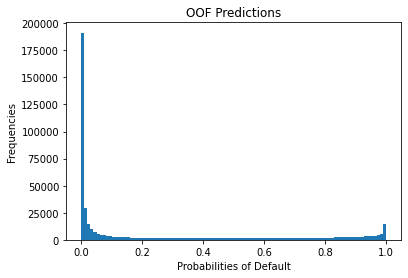

In [19]:
# Plot predictions
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title("OOF Predictions")
plt.xlabel("Probabilities of Default")
plt.ylabel("Frequencies")
plt.show()

In [20]:
# Clear VRAM and Ram
del oof_xgb, oof
_ = gc.collect()

### Feature Importance

We examine the feature importance lists of the five folds. First we merge the five frames to create one single frame.

In [21]:
feat_imp = reduce(lambda x, y: x.merge(y, on="feature", how="left"), importances)
feat_imp

,feature,importance_0,importance_1,importance_2,importance_3,importance_4
0,P_2_mean,159.0,140.0,152.0,129.0,165.0
1,P_2_std,74.0,44.0,71.0,50.0,59.0
2,P_2_min,139.0,130.0,126.0,113.0,144.0
3,P_2_max,161.0,113.0,100.0,110.0,105.0
4,P_2_last,330.0,359.0,311.0,330.0,352.0
...,...,...,...,...,...,...
812,D_64_nunique,4.0,5.0,11.0,7.0,6.0
813,D_66_last,34.0,30.0,37.0,33.0,35.0
814,D_66_nunique,9.0,10.0,10.0,NaN,7.0
815,D_68_last,9.0,4.0,10.0,3.0,6.0


We can compute the mean feature importance for each feature across all five folds:

In [22]:
# The features go down and the folds go across
# Exclude the first column, which are the feature names, compute the means across
feat_imp["importance"] = feat_imp.iloc[:, 1:].mean(axis=1)
# Sort descending
feat_imp = feat_imp.sort_values("importance", ascending=False)
feat_imp

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
4,P_2_last,330.0,359.0,311.0,330.0,352.0,336.4
9,D_39_last,205.0,198.0,201.0,191.0,191.0,197.2
39,B_3_last,188.0,169.0,167.0,155.0,169.0,169.6
59,B_4_last,158.0,163.0,176.0,162.0,177.0,167.2
69,B_5_last,175.0,168.0,134.0,145.0,123.0,149.0
...,...,...,...,...,...,...,...
713,D_129_max,1.0,NaN,NaN,NaN,NaN,1.0
633,D_110_min,1.0,1.0,NaN,NaN,1.0,1.0
251,D_65_min,1.0,NaN,1.0,NaN,NaN,1.0
160,S_6_max,1.0,NaN,1.0,1.0,NaN,1.0


In [23]:
# Write to disk
feat_imp.to_csv(f"xgb_feature_importance_v{VER}.csv", index=False)

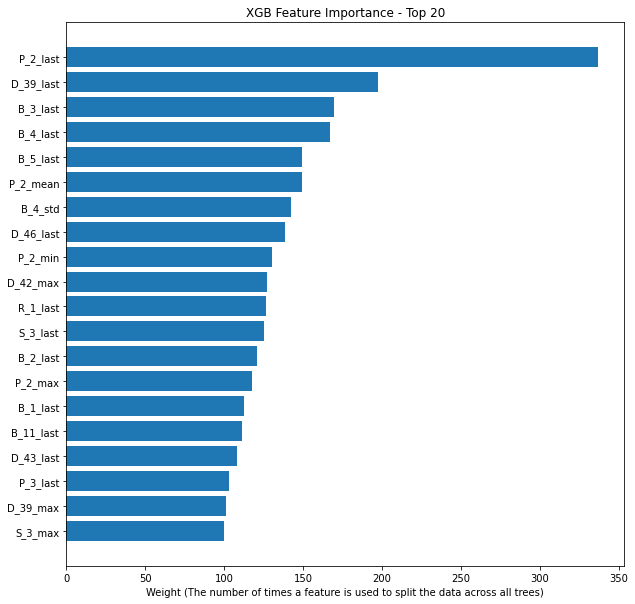

In [24]:
# Size
plt.figure(figsize=(10, 5 * TOP_NUM_FEATURES // 10))

# Horiziontal bar chart
plt.barh(
    y=np.arange(TOP_NUM_FEATURES, 0, -1),
    width=feat_imp.importance.values[:TOP_NUM_FEATURES],
)

# Yticks labels are the feature names
plt.yticks(
    np.arange(TOP_NUM_FEATURES, 0, -1), feat_imp.feature.values[:TOP_NUM_FEATURES]
)
plt.xlabel(
    "Weight (The number of times a feature is used to split the data across all trees)"
)

# Title
plt.title(f"XGB Feature Importance - Top {TOP_NUM_FEATURES}")
plt.show()

## Test Data

Read in test data (specifically, columns `customer_ID` and `S_2`). Then, partition the data into four parts, as defined by the Global constant `NUM_PARTS`.

In [25]:
print(f"Reading test data with columns `customer_ID` and `S_2` ...")
test = read_file(path=TEST_PATH, usecols=["customer_ID", "S_2"])

Reading test data with columns `customer_ID` and `S_2` ...
shape of data: (11363762, 2)


In [26]:
# Return a copy of the array underlying 'customer_ID' collapsed into one dimension
# No duplicates
customers = test[["customer_ID"]].drop_duplicates().sort_index().values.flatten()
rows, num_cust = get_rows(
    customers, test[["customer_ID"]], NUM_PARTS=NUM_PARTS, verbose="test"
)

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2839373, 2841795, 2841688, 2840906]


### Performance Evaluation On Test Data

In [27]:
# Evaluate one part at a time
# Initialize indices
skip_rows = 0
skip_cust = 0
# Containers
test_preds = []

for k in range(NUM_PARTS):
    # Read in one partition of the test data
    print(f"\nReading partition {k + 1} of test data...")

    test = read_file(path=TEST_PATH)
    # The 'rows' list contains the numbers of rows for each partition
    test = test.iloc[skip_rows : skip_rows + rows[k]]
    # Increment the starting index by the numbers of rows for each partition
    skip_rows += rows[k]

    print(f"=> Test partition {k + 1} has shape", test.shape)

    # Process and feature engineering for each partition of the test data
    test = process_and_feature_engineer(test)

    if k == NUM_PARTS - 1:
        # Special handling once we arrive at the lask chunk by simple getting the rest of the remaining rows
        test = test.loc[customers[skip_cust:]]
    else:
        test = test.loc[customers[skip_cust : skip_cust + num_cust]]

    # Increment the ending index by 'num_cust', as each partision has at least 'num_cust' number of unique id's
    skip_cust += num_cust

    # Load test data into a dmatrix
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    # Reduce memory
    test = test[["P_2_mean"]]
    del X_test
    gc.collect()

    # Initializations
    model = xgb.Booster()
    model.load_model(f"XGB_v{VER}_fold0.xgb")
    # This is an numpy array, so we use += below for element-wise addition
    preds = model.predict(dtest)

    for f in range(1, FOLDS):
        model.load_model(f"XGB_v{VER}_fold{f}.xgb")
        # Take the sum of all predictions
        preds += model.predict(dtest)
    # Divide by the number of folds to obtain average prediction for each customer_ID over cv 5 folds
    preds /= FOLDS
    # Append prediction for partition k to container
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading partition 1 of test data...
shape of data: (11363762, 190)
=> Test partition 1 has shape (2839373, 190)
shape after engineering (231155, 918)

Reading partition 2 of test data...
shape of data: (11363762, 190)
=> Test partition 2 has shape (2841795, 190)
shape after engineering (231155, 918)

Reading partition 3 of test data...
shape of data: (11363762, 190)
=> Test partition 3 has shape (2841688, 190)
shape after engineering (231155, 918)

Reading partition 4 of test data...
shape of data: (11363762, 190)
=> Test partition 4 has shape (2840906, 190)
shape after engineering (231156, 918)


### Predictions On Test Data

In [28]:
# Join the 4 partitions of preditions (231155 * 3 + 231156 predictions)
test_preds = np.concatenate(test_preds)

# Create data frame with predictions and customer_ID as row indices
test = cudf.DataFrame(index=customers, data={"prediction": test_preds})

# Read 'customer_ID' column from the sample submission
sub = cudf.read_csv("../input/amex-default-prediction/sample_submission.csv")[
    ["customer_ID"]
]

# Processing
sub["customer_ID_hash"] = sub["customer_ID"].str[-16:].str.hex_to_int().astype("int64")
sub = sub.set_index("customer_ID_hash")

# Left join processed sample submission 'customer_ID' onto prediction data frame using 'customer_ID' as the key
sub = sub.merge(test[["prediction"]], left_index=True, right_index=True, how="left")
sub = sub.reset_index(drop=True)

# Write preditions to file
sub.to_csv(f"test_predictions_xgb_v{VER}.csv", index=False)
print("Prediction file has shape", sub.shape)
sub.head()

Prediction file has shape (924621, 2)


,customer_ID,prediction
0,0f7f94e1247f12d2a38fb2b014d6be7175f51b3b4efe9b...,0.033796
1,0f8086f7297593825bba8c654ea9d35f661089ce25ed79...,0.144461
2,0f7fe57b8ce23fdd299b99cbcf7fac47e0cdf6459bb616...,0.071585
3,0f81168c4911b484975ff222f75321396c546b700fa329...,0.049183
4,0f7f94e3f0e63573b61dccc9fb3c4091ccc8d283d7b58a...,0.011041


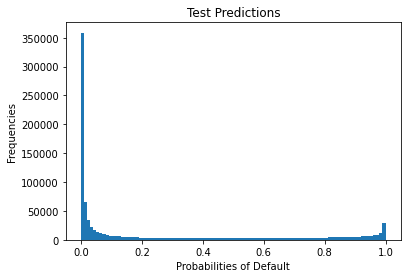

In [29]:
# Visualize
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title("Test Predictions")
plt.xlabel("Probabilities of Default")
plt.ylabel("Frequencies")
plt.show()